In [1]:
import psycopg2
import pandas as pd
import numpy as np
import pickle

from db_config import *

In [2]:
params = get_db_params()

In [3]:
conn = psycopg2.connect(**params)

In [4]:
c = conn.cursor()

In [5]:
query = """
SELECT *
FROM orders;
"""

df_orders = pd.read_sql_query(query, conn)
df_orders.head(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0


In [6]:
mask = df_orders.user_id == 611
df_orders[mask].shape

(17, 7)

In [7]:
query = """
SELECT *
FROM orders;
"""

df_orders = pd.read_sql_query(query, conn)

In [8]:
df_orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [9]:
df_orders.groupby('user_id').agg('count').head(3)

,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,,,
1,11,11,11,11,11,10
2,15,15,15,15,15,14
3,13,13,13,13,13,12


In [10]:
query = """
SELECT *
FROM prior_orders;
"""

df_prior = pd.read_sql_query(query, conn)
df_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0


In [11]:
q = """SELECT * FROM products"""
df_prod = pd.read_sql_query(q, conn)

In [12]:
query = """
SELECT *
FROM train_orders;
"""

df_train = pd.read_sql_query(query, conn)

In [13]:
df_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


Let's take a look at one order in all of the tables we have.

In [14]:
mask = df_orders.order_id == 3421083
df_orders[mask]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
419472,3421083,25247,prior,24,2,6,21.0


In [15]:
mask = df_prior.order_id == 3421083
df_prior[mask]

,order_id,product_id,add_to_cart_order,reordered
32434479,3421083,7854,1,0
32434480,3421083,45309,2,0
32434481,3421083,21162,3,0
32434482,3421083,18176,4,1
32434483,3421083,35211,5,0
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [16]:
mask = df_train.order_id == 3421083
df_train[mask] # does not exist since this is a 'prior' order, not a 'train' order.

,order_id,product_id,add_to_cart_order,reordered


In [17]:
df_train.head(3)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0


In [18]:
df_train.sample()

,order_id,product_id,add_to_cart_order,reordered
48652,119947,49318,18,0


# Table Summary

* `orders`
    * one row per order (index = order_id)
    * does not contain information about reorders
    * `eval_set` indicates whether the order is in the `train`/`test`/`prior`
        * the `test` set is data reserved for the testing of our final model
        * the `prior` and `train` eval_sets are defined below

* `prior_orders`
    * information about orders prior to that users most recent order (~3.2M orders)
    * contains one row per item per order & whether or not each item is a 'reorder'
        * reorder: 1 if products has been ordered by this user in the past, 0 otherwise
    
* `train_orders`
    * training data supplied to participants of Kaggle competition
    * contains one row per item per order & whether or not each item is a 'reorder'(for training data)
    * none of the rows in `train_orders` will be found in `prior_orders`
   
    

In [19]:
df_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


Let's pick one user and pull all of their data.

In [20]:
df_orders.sample()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1212753,449111,72928,prior,16,2,15,30.0


The `user_id` of the sample I pulled originally is `206086`. This will change when you re-run the cell, but it doesn't matter as this is just for sake of understanding.

The issue with the `df_prior` and `df_train` tables is that there is no `user_id` column/foreign key in `df_train` nor `df_prior`.

So, let's query the `instacart` database again to get a dataframe with each order and their user ID.

In [21]:
query_order_info = """
SELECT order_id, user_id FROM orders
"""

df_map = pd.read_sql_query(query_order_info, conn)
df_map

,order_id,user_id
0,2539329,1
1,2398795,1
2,473747,1
3,2254736,1
4,431534,1
...,...,...
3421078,2266710,206209
3421079,1854736,206209
3421080,626363,206209
3421081,2977660,206209


In [22]:
df_map.sample(10, random_state=0)

,order_id,user_id
2356430,3148837,141850
2777371,2196491,167442
2446071,1185907,147186
583888,2792618,35179
1116796,2958416,67185
197784,2615619,11980
2800015,3238115,168921
1658737,1703304,99592
3343130,1238569,201530
1222576,817319,73486


In [23]:
# zoom in on one order: 1846322. The query showing user_id = 142421. Let's confirm
mask = df_orders.order_id == 1846322
df_orders[mask]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
2366071,1846322,142421,prior,16,0,15,21.0


Nice! That seemed to work. Now let's query from this result to bring `user_id` into `df_train` and `df_prior`.

In [24]:
df_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [25]:
df_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [26]:
q = """
SELECT train_orders.order_id, train_orders.product_id,
    train_orders.add_to_cart_order, train_orders.reordered,
    map.user_id, map.eval_set, map.order_number,
    map.order_dow, map.order_hour_of_day, map.days_since_prior_order
FROM train_orders
LEFT JOIN
    (
        SELECT * FROM orders
    ) AS map
ON train_orders.order_id = map.order_id
"""

df_train = pd.read_sql_query(q, conn)
df_train

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,6129,24852,1,1,38907,train,7,1,14,30.0
1,6129,48364,2,1,38907,train,7,1,14,30.0
2,6129,21903,3,1,38907,train,7,1,14,30.0
3,6129,7806,4,1,38907,train,7,1,14,30.0
4,6129,27966,5,1,38907,train,7,1,14,30.0
...,...,...,...,...,...,...,...,...,...,...
1384612,3420084,21783,18,1,9808,train,9,6,21,30.0
1384613,3420084,40228,19,1,9808,train,9,6,21,30.0
1384614,3420084,47935,20,0,9808,train,9,6,21,30.0
1384615,3420084,9491,21,0,9808,train,9,6,21,30.0


In [27]:
df_train.sample(random_state=0)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
276026,2806829,365,3,1,66844,train,87,0,21,4.0


In [28]:
mask = df_orders.order_id == 2806829
df_orders[mask]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1111006,2806829,66844,train,87,0,21,4.0


In [29]:
mask = (df_train.order_id == 2806829) & (df_train.product_id == 365)
df_train[mask]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
276026,2806829,365,3,1,66844,train,87,0,21,4.0


**SWEET! That worked!**

Now let's do the same for `df_prior`.

In [30]:
q = """
SELECT prior_orders.order_id, prior_orders.product_id,
    prior_orders.add_to_cart_order, prior_orders.reordered,
    map.user_id, map.eval_set, map.order_number,
    map.order_dow, map.order_hour_of_day, map.days_since_prior_order
FROM prior_orders
LEFT JOIN
    (
        SELECT * FROM orders
    ) AS map
ON prior_orders.order_id = map.order_id
"""

df_prior = pd.read_sql_query(q, conn)
df_prior

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,114,24954,1,0,91891,prior,1,0,11,NaN
1,114,1688,2,0,91891,prior,1,0,11,NaN
2,114,37371,3,0,91891,prior,1,0,11,NaN
3,114,5782,4,0,91891,prior,1,0,11,NaN
4,114,1263,5,0,91891,prior,1,0,11,NaN
...,...,...,...,...,...,...,...,...,...,...
32434484,3420991,47209,12,1,186459,prior,16,1,9,7.0
32434485,3420991,43122,13,1,186459,prior,16,1,9,7.0
32434486,3421064,37687,1,1,76586,prior,38,5,15,9.0
32434487,3421064,39001,2,1,76586,prior,38,5,15,9.0


In [31]:
df_prior.shape

(32434489, 10)

In [32]:
df_prior.sample(random_state=0)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
8044718,2753911,42356,9,1,77701,prior,4,0,15,25.0


In [33]:
mask = df_orders.order_id == 2753911
df_orders[mask]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1292214,2753911,77701,prior,4,0,15,25.0


In [34]:
mask = (df_prior.order_id == 2753911) & (df_prior.product_id == 42356)
df_prior[mask]

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
8044718,2753911,42356,9,1,77701,prior,4,0,15,25.0


Let's group our orders by user, and see how many orders we have per user.

In [35]:
orders_per_user = df_orders.groupby("user_id")[['order_id']].agg('count')
orders_per_user

,order_id
user_id,
1,11
2,15
3,13
4,6
5,5
...,...
206205,4
206206,68
206207,17


Median number of orders:  10.0


Text(0.5, 0.98, 'Distribution of User Order Counts')

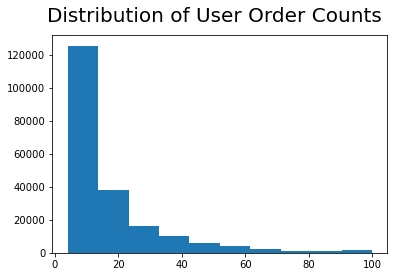

In [36]:
import matplotlib.pyplot as plt

print("Median number of orders: ", orders_per_user.order_id.median())
fig = plt.figure()
plt.hist(orders_per_user)
fig.suptitle("Distribution of User Order Counts", fontsize=20)

Now we need to get all data from departments and aisles into `df_train` and `df_prior`.

Let's first create a working subquery that we will query from in the 2nd cell below here.

In [37]:
q = """
    SELECT * FROM products
    LEFT JOIN aisles
    ON products.aisle_id = aisles.aisle_id
    
"""
pd.read_sql_query(q, conn).head(2)

,product_id,product_name,aisle_id,department_id,aisle_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,61,cookies cakes
1,2,All-Seasons Salt,104,13,104,spices seasonings


In [38]:
df_dpt.head(3)

NameError: name 'df_dpt' is not defined

That's what I wanted. Now let's query from the above subquery to combine the columns from all three tables (`aisles`, `departments`, `products`) together into a `df_prod_detail` dataFrame.

**NOTE**: I will not actually modify the database in this notebook. This was done in the ``db_create.sql`` script.

In [ ]:
q = """
    SELECT * FROM departments
    RIGHT JOIN (
        SELECT * FROM products
        LEFT JOIN aisles
        ON products.aisle_id = aisles.aisle_id
    ) AS prod_detail
    ON prod_detail.department_id = departments.department_id
"""

df_prod_detail = pd.read_sql_query(q, conn)
df_prod_detail.head(1)

In [ ]:
df_prod_detail.columns

Now let's also pull this information into df_train and df_prior.

In [ ]:
df_prior.head(1)

In [ ]:
q = """
    SELECT prior_orders.order_id, prior_orders.add_to_cart_order, prior_orders.reordered, 
        'department_id', 'department', 'product_id', 'product_name', 'aisle_id'
        
    FROM prior_orders
    
    LEFT JOIN product_detail
    
    ON prior_orders.product_id = product_detail.product_id
    
"""
prior2 = pd.read_sql_query(q, conn)
prior2.head(5)